# Classification. Linear models and KNN

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## Part 1: Implementing Logistic Regression

In this task you need to implement Logistic Regression with l2 regularization using gradient descent algorithm.

Logistic Regression loss:
$$ L(w) = \dfrac{1}{N}\sum_{i=1}^N \log(1 + e^{-\langle w, x_i \rangle y_i}) + \frac{1}{2C} \lVert w \rVert^2  \to \min_w$$
$$\langle w, x_i \rangle = \sum_{j=1}^n w_{j}x_{ij} + w_{0},$$ $$ y_{i} \in \{-1, 1\}$$ where $n$ is the number of features and $N$ is the number of samples.

Gradient descent step:
$$w^{(t+1)} := w^{(t)} + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w^{(t)}, x_i \rangle y_i)}\Big) - \eta \frac{1}{C} w,$$
where $\eta$ is the learning rate.

**(2 points)** Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes  should correspond to {-1, 1} labels.

Stopping criteria: either the number of iterations exceeds *max_iter* or $||w^{(t+1)} - w^{(t)}||_2 < tol$.

In [3]:
from sklearn.exceptions import NotFittedError

In [545]:
class CustomLogisticRegression:
    _estimator_type = "classifier"
    
    def __init__(self, eta=0.001, max_iter=1000, C=1.0, tol=1e-5, random_state=42, zero_init=False):
        """Logistic Regression classifier.
        
        Args:
            eta: float, default=0.001
                Learning rate.
            max_iter: int, default=1000
                Maximum number of iterations taken for the solvers to converge.
            C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.
            tol: float, default=1e-5
                Tolerance for stopping criteria.
            random_state: int, default=42
                Random state.
            zero_init: bool, default=False
                Zero weight initialization.
        """
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed=random_state)
        self.zero_init = zero_init
        self.loss_array = []
         
    def get_sigmoid(self, X, weights):
        """Compute the sigmoid value."""           
        sig_val = []
        i = 0
        while i < (X.shape[0]):
            sig_val.append(1 / (1 + math.exp(-np.dot(X[i,:],weights))))
            i = i + 1
        return np.array(sig_val)
        
    
    
#     def get_loss(self, x, weights, y):
    def get_loss(self, X, weights, y):
        """Calculate the loss."""
        
        N = X.shape[0]        
        w = np.zeros(shape=(N,1))
        for i in range(N):
            val = 1 + math.exp(-np.multiply(np.dot(weights, X[i,:]),y[i]))
            w[i] = math.log(val)
            
        loss = w.sum() / N + np.linalg.norm(weights)**2/(2*self.C);
#         print(f'loss: {loss}')
        return loss

 
    def get_delta(self, X, weights, y):
        N = X.shape[0]
        n = X.shape[1]

        w = np.zeros(shape=(N,n))
        for i in range(N):
            val = 1 - 1/(1 + math.exp(-np.multiply(np.dot(weights, X[i,:]),y[i])))
            w[i,:] = X[i,:]*y[i]*val
            
        delta = w.sum(axis = 0)/ N * self.eta - weights/self.C*self.eta;
        return delta
    
    
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) # a constant feature is included to handle intercept
        self.loss_array = []
        
        num_features = X_ext.shape[1]
        if self.zero_init:
            self.weights_ = np.zeros(num_features) 
        else:
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(low=-weight_threshold,
                                                      high=weight_threshold, size=num_features) # random weight initialization
            
        for i in range(self.max_iter):
#             delta = "<your code>"

            delta = self.get_delta(X_ext, self.weights_, y)
            self.weights_ += delta
        
            loss = self.get_loss(X_ext, self.weights_, y)
            loss_array = self.loss_array.append(loss)
            
            if np.linalg.norm(delta) < self.tol: 
                break
                
#         print(f'result weights: {self.weights_}')
#         print(f'loss array: {self.loss_array}')
        
     
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return self.get_sigmoid(X_ext, self.weights_)
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        return [1 if v > 0.5 else -1 for v in self.predict_proba(X)]

        

In [546]:
from sklearn import datasets
from sklearn import metrics

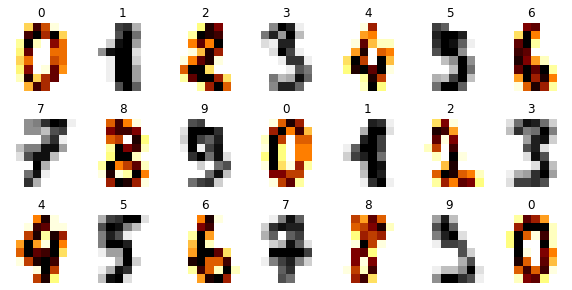

In [547]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1

In [549]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()

In [590]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)


def fit_evaluate_without_plot(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

In [551]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)

In [552]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))

In [553]:
lr_clf.fit(X_train, y_train)

In [554]:
assert np.allclose(lr_clf.weights_, np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,
        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,
        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,
        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,
       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,
        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,
        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,
       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,
        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,
        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]), atol=1e-5)

In [555]:
model = CustomLogisticRegression()

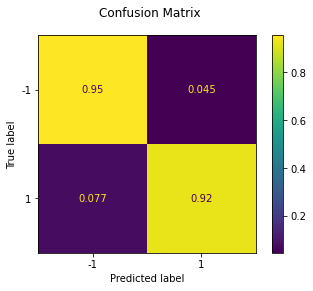

In [556]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [557]:
train_acc, test_acc

(0.9109255393180237, 0.9388888888888889)

In [558]:
assert min(train_acc, test_acc) > 0.9

**(0.5 points)** Visualize the loss history.

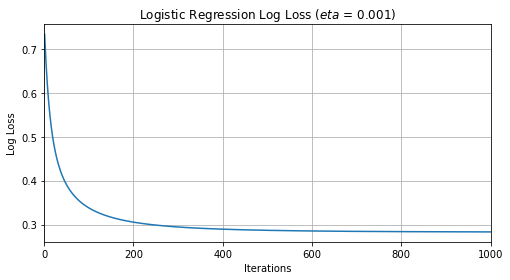

In [575]:
iterations = np.arange(1, len(model.loss_array)+1)

plt.figure(figsize=(8,4))
plt.plot(iterations, model.loss_array)
plt.title('Logistic Regression Log Loss ($eta$ = 0.001)')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.xlim(0,1000)
plt.grid()
plt.show()

**(0.5 points)** Try different learning rates and compare the results. How does the learning rate influence the convergence?

Для оценки влияния скорости обучения (learning rate) на итоговую точность классификации и сходимость функции потерь (Log Loss) сформируем дополнетельные модели предсказания для `eta = [0.1, 0.01]`.

- Логистическая регрессия с `eta=0.01`.

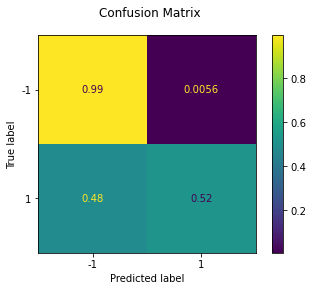

(0.7731384829505915, 0.7527777777777778)

In [560]:
model_01 = CustomLogisticRegression(eta=0.01)
train_acc_01, test_acc_01 = fit_evaluate(model_01, X_train, y_train, X_test, y_test)
train_acc_01, test_acc_01

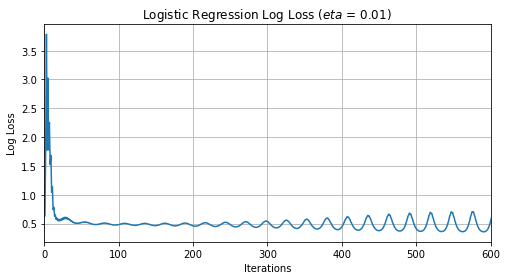

In [579]:
iterations_01 = np.arange(1, len(model_01.loss_array)+1)

plt.figure(figsize=(8,4))
plt.plot(iterations, model_01.loss_array)
plt.title('Logistic Regression Log Loss ($eta$ = 0.01)')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.grid()
plt.xlim(0,600)
plt.show()

- Логистическая регрессия с `eta=0.1`.

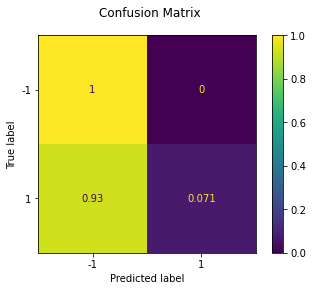

(0.5455810716771051, 0.5277777777777778)

In [561]:
model_1 = CustomLogisticRegression(eta=0.1)
train_acc_1, test_acc_1 = fit_evaluate(model_1, X_train, y_train, X_test, y_test)
train_acc_1, test_acc_1

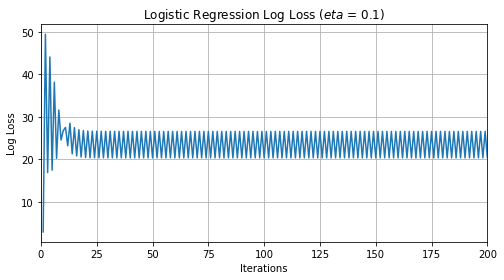

In [572]:
iterations_1 = np.arange(1, len(model_1.loss_array)+1)

plt.figure(figsize=(8,4))
plt.plot(iterations, model_1.loss_array)
plt.title('Logistic Regression Log Loss ($eta$ = 0.1)')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.grid()
plt.xlim(0,200)
plt.show()

**Выводы:**

- Как следует из графиков выше, с увеличением параметра `eta` ухудшается сходимость ряда функции потерь (Log Loss). Так для `eta=0.001` кривая функции потерь гладкая и монотонно убывающая. Для больших значений `eta` наблюдаются переколебания, но при этом функция быстрее достигает минимального значения.
- Увеличение скорости обучения также снижает точность распознавания, что отображение в таблице ниже.

| eta | tr_acc | test_acc |
|-----|--------|----------|
|0.001| 0.9109 | 0.9388   |
|0.01 | 0.7731 | 0.7527   |
|0.1  | 0.5456 | 0.5278   |

- Скорость сходимости в данном случае разменивается на точность распознавания


**(0.5 points)** Try different regularization parameter values and compare the model quality.

In [596]:
C = [0.5, 0.75, 1, 1.25, 1.5, 2, 3, 4, 5, 10, 50]

train_acc_c = []
test_acc_c = []
for c in C:
    model_СX = CustomLogisticRegression(C=c)
    tr, tst = fit_evaluate_without_plot(model_СX, X_train, y_train, X_test, y_test)
    train_acc_c.append(tr)
    test_acc_c.append(tst)

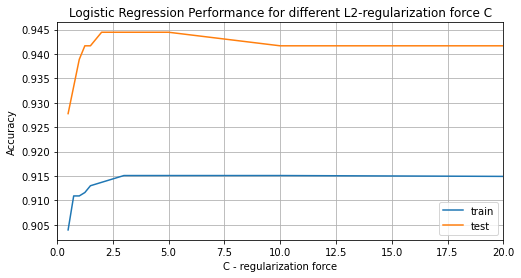

In [597]:
plt.figure(figsize=(8,4))
plt.plot(C, train_acc_c)
plt.plot(C, test_acc_c)
plt.title('Logistic Regression Performance for different L2-regularization force C')
plt.xlabel('C - regularization force')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'])
plt.grid()
plt.xlim(0,20)
plt.show()

In [646]:
df = pd.DataFrame(train_acc_c, index=C, columns = ['train_acc'])
df['test_acc'] = test_acc_c
df.head(20)

,train_acc,test_acc
0.50,0.903967,0.927778
0.75,0.910926,0.933333
1.00,0.910926,0.938889
1.25,0.911621,0.941667
1.50,0.913013,0.941667
2.00,0.913709,0.944444
3.00,0.915101,0.944444
4.00,0.915101,0.944444
5.00,0.915101,0.944444
10.00,0.915101,0.941667


**Выводы**:
- Из графика выше следует, что изменением параметра регуляризации можно добиться определенного увеличения точности классификации в обучающей и тестовой выборке. 
- Кривые точности для обеих выборок имет выраженный пик в диапазоне `C ~= [3,5]`, который и соответствует оптимальным параметрам C. В этом случае достигается максимальная точность распознавания достигает `train_acc= 0.915101` и `test_acc=0.944444`.

**(0.5 points)** Compare zero initialization and random initialization. 

Сравним точностные характеристики модели с нулевыми начальными значениями и моделями со случайными начальными значениями. При этом модель со случайными весами запустим 2 раза.

- запуск №1 обучения модели со случайными начальными весами.

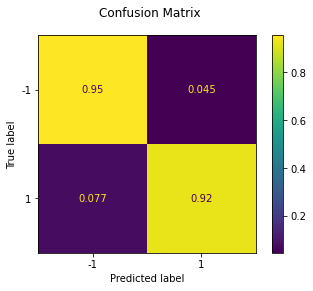

(0.9109255393180237, 0.9388888888888889)

In [648]:
model_rand1 = CustomLogisticRegression(zero_init=False)
train_acc_rand1, test_acc_rand1 = fit_evaluate(model_rand1, X_train, y_train, X_test, y_test)
train_acc_rand1, test_acc_rand1

In [665]:
- запуск №2 обучения модели со случайными начальными весами.

SyntaxError: invalid character '№' (U+2116) (1013873952.py, line 1)

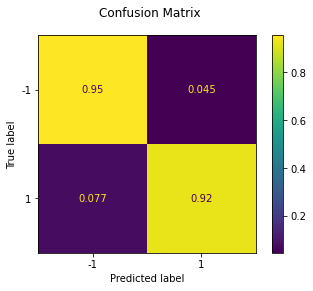

(0.9109255393180237, 0.9388888888888889)

In [653]:
model_rand2 = CustomLogisticRegression(zero_init=False)
train_acc_rand2, test_acc_rand2 = fit_evaluate(model_rand2, X_train, y_train, X_test, y_test)
train_acc_rand2, test_acc_rand2

In [655]:
df = pandas.DataFrame(columns=['train_acc','test_acc'], index=['NoRand','Rand_1','Rand_2'])
df.loc['NoRand'] = pd.Series({'train_acc':train_acc, 'test_acc':test_acc})
df.loc['Rand_1'] = pd.Series({'train_acc':train_acc_rand1, 'test_acc':test_acc_rand1})
df.loc['Rand_2'] = pd.Series({'train_acc':train_acc_rand2, 'test_acc':test_acc_rand2})

df.head()

,train_acc,test_acc
NoRand,0.910926,0.938889
Rand_1,0.910926,0.938889
Rand_2,0.910926,0.938889


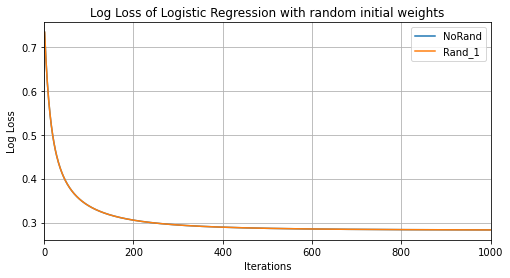

In [664]:
plt.figure(figsize=(8,4))
plt.plot(iterations, model.loss_array)
plt.plot(iterations, model_rand1.loss_array)
plt.title('Log Loss of Logistic Regression with random initial weights')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.legend(['NoRand', 'Rand_1'])
plt.xlim(0,1000)
plt.grid()
plt.show()

**Выводы**:
- начальные значения весов не имеют решающего значения на сходимость Log Loss и точностные характеристики модели. Функции потерь и значения точности для обозначенных режимов полностью совпадают.
- точностные характеристики модели со случайными начальными весами идентичны от обучения к обучению.

## Part 2: Implementing KNN Classifier

In this task you need to implement weighted K-Neighbors Classifier.

Recall that training a KNN classifier is simply memorizing a training sample. 

The process of applying a classifier for one object is to find the distances from it to all objects in the training data, then select the k nearest objects (neighbors) and return the most common class among these objects.

You can also give the nearest neighbors weights in accordance with the distance of the object to them. In the simplest case (as in your assignment), you can set the weights inversely proportional to that distance. 

$$w_{i} = \frac{1}{d_{i} + eps},$$

where $d_{i}$ is the distance between object and i-th nearest neighbor and $eps$ is the small value to prevent division by zero.

In case of 'uniform' weights, all k nearest neighbors are equivalent (have equal weight, for example $w_{i} = 1, \forall i \in(1,k)$).

To predict the probability of classes, it is necessary to normalize the weights of each class, dividing them by the sum:

$$p_{i} = \frac{w_{i}}{\sum_{j=1}^{c}w_{j}},$$

where $p_i$ is probability of i-th class and $c$ is the number of classes.

**(2 points)** Implement the algorithm and use it to classify the digits. By implementing this algorithm, you will be able to classify numbers not only into "even" or "odd", but into their real representation.

In [1001]:
class CustomKNeighborsClassifier:
    _estimator_type = "classifier"
    
    def __init__(self, n_neighbors=5, weights='uniform', eps=1e-9):
        """K-Nearest Neighbors classifier.
        
        Args:
            n_neighbors: int, default=5
                Number of neighbors to use by default for :meth:`kneighbors` queries.
            weights : {'uniform', 'distance'} or callable, default='uniform'
                Weight function used in prediction.  Possible values:
                - 'uniform' : uniform weights.  All points in each neighborhood
                  are weighted equally.
                - 'distance' : weight points by the inverse of their distance.
                  in this case, closer neighbors of a query point will have a
                  greater influence than neighbors which are further away.
            eps : float, default=1e-5
                Epsilon to prevent division by 0 
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.eps = eps
        
    
    def get_pairwise_distances(self, X, Y):
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            P: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance 
                between i'th row from the X and j'th row from the Y.
        """
        if X.shape[1] != Y.shape[1]:
            raise Exception("Number of features in X and Y must be the same!") 
        
        n = X.shape[0]
        k = Y.shape[0]
        
        distances = np.zeros(shape=(n,k))
        for i in range(n):
            for j in range(k):
                
                distances[i,j] = np.linalg.norm(X[i,:] - Y[j,:])
                
#         print(distances)        
        return distances
    
    def get_class_weights(self, y, weights):
        """
        Returns a vector with sum of weights for each class 
        Args:
            y: numpy array of shape (n_samles,)
            weights: numpy array of shape (n_samples,)
                The weights of the corresponding points of y.
        Returns:
            p: numpy array of shape (n_classes)
                Array where the value at the i-th position 
                corresponds to the weight of the i-th class.
        """
        if len(y) != len(weights):
            raise Exception("Number of elements in 'y' and 'weights' must be the same!") 
        
        n = len(self.classes_)
        class_weights = np.zeros(n)
        for i in range(n):
            class_weights[i] = weights[np.array(y == self.classes_[i])].sum()

        return class_weights            
        
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        self.points = X
        self.y = y
        self.classes_ = np.unique(y)
        
        
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples, n_classes)
                Vector containing positive class probabilities.
        """
        if hasattr(self, 'points'):
            
            P = self.get_pairwise_distances(X, self.points)
            weights_of_points = np.ones(P.shape)
            if self.weights == 'distance':
                weights_of_points = 1/(P + eps)
            
            c = len(self.classes_)
            m = X.shape[0]
            M = np.zeros(shape=(m,c))
            for i in range(m):
                zipped = zip(P[i,:], self.y, weights_of_points[i,:])
                zip_sorted = sorted(zipped, key=lambda x: x[0])[:self.n_neighbors]
                y1 = np.array([z[1] for z in zip_sorted])
                w1 = np.array([z[2] for z in zip_sorted])
                _w = self.get_class_weights(y1,w1)
                prob = list(_w/_w.sum())
                M[i,:] = prob
                
            return M
        
        else: 
            raise NotFittedError("CustomKNeighborsClassifier instance is not fitted yet")
    
        
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        
        probs = self.predict_proba(X)
        return [self.classes_[arg] for arg in np.argmax(probs, axis=1)]

In [1002]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [1003]:
assert np.allclose(model.get_pairwise_distances(np.array([[0  , 1]  , [1, 1]]), 
                                                np.array([[0.5, 0.5], [1, 0]])),
                   np.array([[0.70710678, 1.41421356],
                             [0.70710678, 1.        ]]))

In [992]:
model.classes_ = ['one', 'two', 'three']
assert np.allclose(model.get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4])), 
                   np.array([2,4,0]))

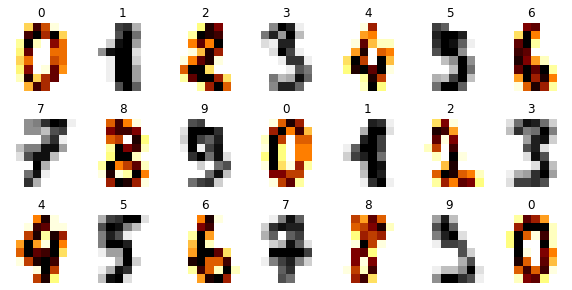

In [993]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [994]:
model.fit(X_train, y_train)
knn.fit(X_train, list(map(str, y_train)));

In [998]:
assert np.allclose(model.predict_proba(X_test), knn.predict_proba(X_test))

probs.shape: (360, 10)
args: [1 1 0 1]
classes_: [0 1 2 3 4 5 6 7 8 9]


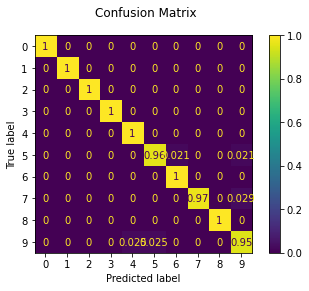

probs.shape: (1437, 10)
args: [1 1 0 1]
classes_: [0 1 2 3 4 5 6 7 8 9]
probs.shape: (360, 10)
args: [1 1 0 1]
classes_: [0 1 2 3 4 5 6 7 8 9]


In [999]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [1000]:
assert train_acc == 1
assert test_acc > 0.98

**(0.5 points)** Take a look at the confusion matrix and tell what numbers the model confuses and why this happens.

< your thoughts >

**(0.5 points)** Try different n_neighbors parameters and compare the output probabilities of the model.

In [ ]:
## your code

< your thoughts >

**(0.5 points)** Compare both 'uniform' and 'distance' weights and share your thoughts in what situations which parameter can be better.

In [ ]:
## your code

< your thoughts >

**(0.5 points)** Suggest another distance measurement function that could improve the quality of the classification for this task. 

< your thoughts >

**(0.5 points)** Suggest different task and distance function that you think would be suitable for it.

< your thoughts >

## Part 3: Synthetic Titanic Survival Prediction

### Dataset

Read the description here: https://www.kaggle.com/c/tabular-playground-series-apr-2021/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview/evaluation.  


In [ ]:
PATH = "./data/"

In [ ]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')

In [ ]:
data.head()

### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [ ]:
## your code

< your thoughts >

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

In [ ]:
## your code

< your thoughts >

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

In [ ]:
## your code

< your thoughts >

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [ ]:
## your code

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

< your thoughts >

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [ ]:
## your code

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [ ]:
## your code

Select the best model, load the test set and make the predictions. Submit them to kaggle and see the results :)

**Note**. X points will depend on your kaggle public leaderboard score.
$$ f(score) = 1.0, \ \ 0.79 \leq score < 0.80,$$
$$ f(score) = 2.5, \ \ 0.80 \leq score < 0.81,$$ 
$$ f(score) = 4.0, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.